In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import glob
import rarfile, os
from collections import Counter
from collections import defaultdict
from PIL import Image
from datetime import datetime
import shutil

def imshow(*args, **kwargs):
    params = dict(cmap=plt.cm.gray, interpolation='nearest')
    params.update(kwargs)
    plt.imshow(*args, **params)

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def getDate(filename, split='\\'):
    if split in filename:
        s = re.findall('\d+', filename.split(split)[-1])[0]
    else:
        s = re.findall('\d+', filename)[0]
    return datetime.strptime(s, '%Y%m%d')

def myround(x, base=2):
    return int(base * round(float(x)/base))


## Cleaning image directory

In [7]:
directories = Counter()
filenames = sorted(glob.iglob('/Users/ajmendez/data/dilbert/images/*/*'))
bad_filenames = []
for i, filename in enumerate(filenames):
#     # First remove sub directories
#     origdir,filename = os.path.split(filename)
#     dirname = os.path.dirname(origdir)
#     shutil.move(os.path.join(origdir,filename), os.path.join(dirname, filename))
    
#     # Filter BW/Color ones
#     bwfilename = filename.replace('-colour', '')
#     if (filename != bwfilename) and (bwfilename in filenames):
#         os.remove(bwfilename)
#         continue
    
#     # Remove small copies
#     sfilename = filename.replace('-small','')
#     if (filename != sfilename) and (sfilename in filenames):
#         os.remove(filename)
#         continue
    
#     # Files without size
#     if os.stat(filename).st_size == 0:
#         os.remove(filename)
#         print(filename)
    
    
    gfilename = filename.replace('.gif', '.jpg')
    if (filename != gfilename) and (gfilename in filenames):
        os.remove(gfilename)
        continue
    
    
    
    directories[os.path.basename(os.path.dirname(filename))] += 1
directories.most_common(1000)

[('dilbert2007', 367),
 ('dilbert2006', 367),
 ('dilbert1996', 366),
 ('dilbert1999', 366),
 ('dilbert1998', 366),
 ('dilbert1992', 366),
 ('dilbert2000', 366),
 ('dilbert2004', 366),
 ('dilbert1990', 365),
 ('dilbert2010', 365),
 ('dilbert1994', 365),
 ('dilbert2001', 365),
 ('dilbert2002', 365),
 ('dilbert2009', 365),
 ('dilbert2012', 365),
 ('dilbert1991', 365),
 ('dilbert2014', 365),
 ('dilbert2003', 365),
 ('dilbert2008', 365),
 ('dilbert1993', 365),
 ('dilbert1995', 365),
 ('dilbert1997', 365),
 ('dilbert2005', 364),
 ('dilbert2015', 364),
 ('dilbert2013', 364),
 ('dilbert2011', 364),
 ('dilbert1989', 258)]

In [40]:
simplesizes = defaultdict(list)
simpleshapes = defaultdict(list)
filenames = sorted(glob.iglob('/Users/ajmendez/data/dilbert/images/*/*'))
for filename in filenames:
    with Image.open(filename) as img:
        key = (myround(img.height), myround(img.width))
        simplesizes[key].append(filename)
        simpleshapes[key].append((img.height, img.width))
        

In [41]:
sorted(map(lambda x: (x[0], len(x[1])), simplesizes.items()), key=lambda x: -x[-1])[:10]

[((200, 640), 2008),
 ((196, 640), 1058),
 ((212, 600), 930),
 ((208, 600), 495),
 ((216, 600), 480),
 ((210, 600), 362),
 ((288, 640), 345),
 ((516, 724), 313),
 ((280, 900), 300),
 ((214, 600), 299)]

In [ ]:
np.sort()

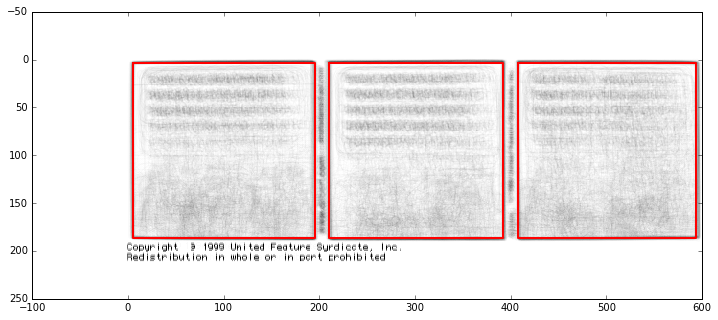

In [113]:
def plotBox(xmin, xmax, ymin, ymax):
    plt.plot([xmin, xmax, xmax, xmin, xmin],
             [ymin, ymin, ymax, ymax, ymin], color='r', lw=2)

def threshold(img, thresh=60):
    Y = np.zeros(img.shape)+255
    Y[img < thresh] = img[img < thresh]
    return(Y)

def getOffsets(im, sep=120, axis=1):
    m = np.mean(im, axis=axis)
    thresh = np.percentile(m, 2)
    s = np.std(im, axis=axis)
    sthresh = np.percentile(s, 2)
    pts = np.where((m<thresh) | (s<sthresh))[0]
    lines = np.sort(np.concatenate([[0], pts, [im.shape[i]]]))
    delta = np.diff(lines)
    offsets = lines[np.where(delta > xm)[0]]
    sizes = delta[np.where(delta > xm)[0]]
    for offset,size in zip(offsets, sizes):
        yield offset, offset+size

def carve(img, nx=120, ny=120, linethresh=None):
    Y = threshold(img)
    Y = img
    ymean = np.mean(Y, axis=1)
    linethresh = np.percentile(np.mean(Y, axis=1), 2)
    ylines = np.where(np.mean(Y,1)<linethresh)[0]
    lines = np.sort(np.concatenate([[0], ylines,[img.shape[0]]]))
    
    deltas = np.diff(lines)
    yoffsets = lines[np.where(deltas>ny)[0]]#[::2]
    heights = deltas[np.where(deltas>ny)[0]]#[::2]
    
    for yoffset,height in zip(yoffsets, heights):
        X = Y[yoffset:yoffset+height,:]
        xmean = np.mean(X, axis=0)
        xthresh = np.percentile(xmean, 2)
        xlines = np.where(xmean < xthresh)[0]
        
        lines = np.sort(np.concatenate([[0], xlines, [img.shape[1]]]))
        deltas = np.diff(lines)
        xoffsets = lines[np.where(deltas>nx)[0]]#[::2]
        widths = deltas[np.where(deltas>nx)[0]]#[::2]
        
        for xoffset, width in zip(xoffsets, widths):
            yield xoffset, xoffset+width, yoffset, yoffset+height

            
# plt.figure(figsize=(12,6))
# imshow(image)
# for box in carve(image):
#     plotBox(*box)

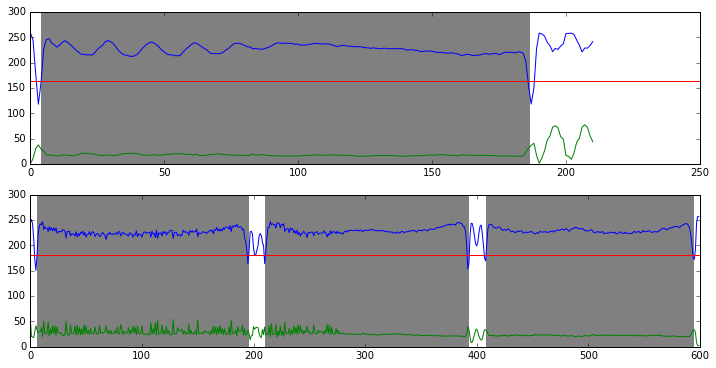

In [112]:
def oned(im, xm=120, axis=1):
    m = np.mean(im, axis=axis)
    plt.plot(m)
    thresh = np.percentile(m, 2)

    s = np.std(im, axis=axis)
    plt.plot(s)
    sthresh = np.percentile(s, 2)

    plt.axhline(thresh, color='orange')
    plt.axhline(thresh, color='red')
    pts = np.where((m<thresh) | (s<sthresh))[0]
    lines = np.sort(np.concatenate([[0], pts, [im.shape[i]]]))
    delta = np.diff(lines)
    offsets = lines[np.where(delta > xm)[0]]
    heights = delta[np.where(delta > xm)[0]]
    for offset, height in zip(offsets, heights):
        plt.axvspan(offset, offset+height, zorder=2, color='0.5')
for i, ax in enumerate(plt.subplots(2,1, figsize=(12,6))[1]):
    plt.sca(ax)
    oned(image, axis=1-i)

In [127]:
nskip = 5000
bad = []
params = {}
for j,((height,width),filenames) in enumerate(sorted(simplesizes.items(), key=lambda x: -len(x[-1]))):
#     if len(filenames) < 2:
#         continue
#     if j < 2:
#         continue
#     if j not in bad:
#         continue
    key = (height,width)
    shapes = simpleshapes[key]
    image = np.zeros(np.min(shapes, axis=0))
    for i,filename in enumerate(filenames):
        if i > nskip:
            continue
        try:
            x = plt.imread(filename)
        except Exception as e:
            print(e)
            print(filename)
            continue
        if len(x.shape) in [3,4]:
            x = rgb2gray(x)
        image += x[:image.shape[0], 
                   :image.shape[1]]*1.0/np.min([nskip, len(shapes)])
    outfilename = '/Users/ajmendez/data/dilbert/stacks_bad/stack_{:03d}.png'.format(j)
    if os.path.exists(outfilename):
        continue
    
    outfilename = '/Users/ajmendez/data/dilbert/stacks/stack_{:03d}.png'.format(j)
#     plt.imsave(outfilename, image, cmap=plt.cm.gray)
    
    plt.figure(figsize=(12,6))
    imshow(image)
    params[key] = []
    for box in carve(image):
        plotBox(*box)
        params[key].append(box)
    plt.title((height,width,len(filenames)))
    plt.savefig(outfilename.replace('.png', '.fig.png'))
    plt.close()
#     break

In [120]:
from pprint import pformat, pprint

In [124]:
# pprint(params, width=1000)

In [125]:
# params2 = {}
# for j,((height,width),filenames) in enumerate(sorted(simplesizes.items(), key=lambda x: -len(x[-1]))):
#     params2[j] = params[(height,width)]

In [126]:
# pprint(params2, width=1000)

{0: [(2, 202, 1, 197), (220, 421, 1, 197), (439, 638, 1, 197)],
 1: [(2, 204, 1, 193), (221, 418, 1, 193), (434, 637, 1, 193)],
 2: [(5, 191, 5, 185), (208, 393, 5, 185), (409, 594, 5, 185)],
 3: [(5, 191, 5, 185), (208, 393, 5, 185), (410, 594, 5, 185)],
 4: [(6, 192, 6, 187), (208, 391, 6, 187), (392, 593, 6, 187)],
 5: [(5, 191, 5, 185), (208, 393, 5, 185), (410, 595, 5, 185)],
 6: [(1, 152, 1, 138), (163, 314, 1, 138), (325, 477, 1, 138), (487, 638, 1, 138), (1, 152, 148, 285), (163, 314, 148, 285), (325, 477, 148, 285), (487, 638, 148, 285)],
 7: [(4, 173, 156, 486), (175, 355, 156, 486), (369, 538, 156, 486), (552, 720, 156, 486)],
 8: [(3, 285, 3, 277), (310, 592, 3, 277), (618, 897, 3, 277)],
 9: [(6, 191, 6, 186), (208, 392, 6, 186), (393, 594, 6, 186)],
 10: [(7, 195, 9, 191), (212, 393, 9, 191), (409, 596, 9, 191)],
 11: [(7, 195, 8, 188), (211, 391, 8, 188), (407, 592, 8, 188)],
 12: [(5, 192, 4, 186), (208, 388, 4, 186), (404, 591, 4, 186)],
 13: [(7, 196, 11, 193), (212, 